# 驗證碼辨識-YOLO

專案目標是辨識 [Kaggle 驗證碼資料](https://www.kaggle.com/genesis16/captcha-4-letter)，這次將採用 **YOLO v3** 模型先找出每個字元的位置，再對每個字元逐一辨識，這種方法彈性更高，可以解決驗證碼字元位置分布不固定的問題，以下為此專案的大致步驟，其中，步驟 1,2 會放在 README.md 文檔中做說明:
 1. 標註驗證碼圖像
 2. 將標註過的驗證碼圖像放進 **YOLO v3** 模型訓練
 3. 使用 **YOLO v3** 模型對驗證碼圖像的字元識別並剪裁
 4. 將剪裁圖像放入捲積神經網路進行訓練

## Step0: 導入模塊與載入 YOLO v3 模型

In [1]:
from platform import python_version
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import glob

print('Python Version: ', python_version())
print('TensorFlow Version: ', tf.__version__)
print('NumPy Version: ', np.__version__)
print('OpenCV Version: ', cv2.__version__)

Python Version:  3.7.8
TensorFlow Version:  2.4.1
NumPy Version:  1.19.5
OpenCV Version:  4.5.1


In [2]:
# 載入 YOLO v3 模型
weight_file = 'yolov3_training_2000.weights'
cfg_file = 'yolov3_testing.cfg'
classes = ['char']

net = cv2.dnn.readNet(weight_file, cfg_file)
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

## Step1: 定義 find_bbox 函數
find_bbox 函數會找出圖像的 bounding boxes，如下圖所示。
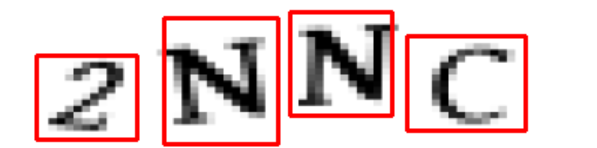

In [17]:
# https://www.youtube.com/watch?v=h56M5iUVgGs

def find_bbox(img_path):
    """
    return img, bboxes
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (400, 100), interpolation=cv2.INTER_AREA)
    
    height, width, channels = img.shape

    # 圖像預處理
    # bolbs 有一個元素，該元素的 shape 為 (3, 416, 416)
    blobs = cv2.dnn.blobFromImage(img, 
                                  0.00392, # rescale 
                                 (416, 416), # 不能改，訓練時就是使用這個形狀當作輸入
                                 (0, 0, 0), # minus each channel 
                                 True, # swap 'rgb' mode 
                                 crop=False)
    
    # 輸入 blobs 到 nn 
    net.setInput(blobs)
    # 取得 nn 輸出 
    outs = net.forward(output_layers)

    confidences = []
    boxes = [] 
    
    # outs 長度為 3，會偵測 bolbs 中每個元素三個 channel 對應的 detection
    # detection 對應的是每一個 bbox 的訊息 
    # detection[0]: bbox 中心點 x 座標, detection[1]: bbox 中心點 y 座標 (使用比例衡量)
    # detection[2]: bbox 寬度, detection[3]: bbox 長度 (使用比例衡量)
    # detection[5:]: 各類別的 confidence score vector 

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
    
    # NMS 的四個參數 boxes, confidences, score_threshold, nms_threshold
    # boxes
    # confidence: 長度與 boxes 一樣
    # score_threshold: 過濾掉 confidence 小於這個值的 boxes
    # nms_threshold: 過濾掉 IOU 大於這個值得 boxes
    # 返回: 剩下的 boxes 對應的 indexes，shape 為 (剩下 boxes 個數, 1)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    if indexes.shape[0] != 4:
        return 
    extracted_boxes = [boxes[indexes[0,0]], boxes[indexes[1,0]], boxes[indexes[2,0]], boxes[indexes[3,0]]]
    
    # 對 extracted_boxes 進行排序，從左到右排
    extracted_boxes.sort(key=lambda x: x[0])
    return img, extracted_boxes

In [ ]:
# 範例
img, extracted_boxes = find_bbox('./captcha/2NNC.png')

for i in range(len(extracted_boxes)):
    x, y, w, h = extracted_boxes[i]
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

cv2.imshow('Character Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Step2: 建立訓練, 驗證與測試集
訓練與驗證集的資料為對原始驗證碼圖像剪裁後的圖像，會使用上一步驟定義的 find_bboxes 函數對驗證碼圖像進行剪裁，測試集圖像則為原始驗證碼圖像。

In [3]:
# 訓練, 測試分割
images_path = np.array(glob.glob('./captcha/*.png'))
np.random.shuffle(images_path)

train_images_path = images_path[:1200]
test_images_path = images_path[1200:1400]

In [ ]:
# 新增資料夾, 作為訓練與測試
os.mkdir('./crop_image/')
os.mkdir('./crop_image/train')
os.mkdir('./crop_image/test')

In [23]:
# 建立訓練集
char_dict = {}
count = 0

# size of every cropped image after resizing
img_height, img_width, channel = 50, 36, 1 

# crop images 
for img_path in train_images_path:
    try:
        img, extracted_boxes = find_bbox(img_path)
        label = img_path.split(os.path.sep)[-1].split('.')[0]
    except:   # if the image cannot correctly recognize
        count += 1
        continue 
    
    for i in range(4): 
        char = label[i]
        x, y, w, h = extracted_boxes[i]
        x, y = abs(x), abs(y)
        save_path = './crop_image/train/' + char + '/'
        if char in char_dict: 
            char_dict[char] += 1
        else: 
            char_dict[char] = 1
            os.mkdir(save_path)
        # shape of cropped images after resizing: (50,36,3)
        crop_img = cv2.resize(img[y:y+h, x:x+w], (img_width, img_height), interpolation=cv2.INTER_AREA)
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(save_path + char + '_' + str(char_dict[char]) + '.png', crop_img)
        
labels = [img_path.split(os.path.sep)[-1].split('.')[0] for img_path in images_path]
characters = list(set(char for label in labels for char in label))
characters.sort()

print('訓練集無法正確辨識的圖片數量:', count)
print('整個資料集出現的所有字元:', characters)
print('訓練集出現的字元:', os.listdir('./crop_image/train/'))

訓練集無法正確辨識的圖片數量: 35
整個資料集出現的所有字元: ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
訓練集出現的字元: ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
characters = ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [4]:
# 建立測試集
for img_file in test_images_path: 
    file_name = img_file.split(os.path.sep)[-1]
    shutil.copy(img_file, './crop_image/test/' + file_name)

In [7]:
# 建立 train, validation dataset 
batch_size = 32 
img_height, img_width, channel = 50, 36, 1 
num_classes = len(characters)

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    './crop_image/train/',
    labels='inferred',
    label_mode='categorical',  
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed = 1314,
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    './crop_image/train/',
    labels='inferred',
    label_mode='categorical',  
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed = 1314,
)

def data_preprocess(img, label):
    return img/255, label

ds_train = ds_train.map(data_preprocess)
ds_validation = ds_validation.map(data_preprocess)

Found 4660 files belonging to 32 classes.
Using 4194 files for training.
Found 4660 files belonging to 32 classes.
Using 466 files for validation.


## Step3: 建立,編譯與訓練模型

In [8]:
# 建立模型
model = keras.Sequential(
    [
        keras.Input(shape=(img_height, img_width, channel)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# 編譯模型
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 7, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4928)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4928)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [9]:
# 訓練模型
history = model.fit(ds_train, epochs=50, validation_data=ds_validation)

Epoch 1/50
132/132 [==============================] - 20s 139ms/step - loss: 2.3195 - accuracy: 0.4005 - val_loss: 0.2402 - val_accuracy: 0.9421
Epoch 2/50
132/132 [==============================] - 13s 98ms/step - loss: 0.1688 - accuracy: 0.9549 - val_loss: 0.1812 - val_accuracy: 0.9657
Epoch 3/50
132/132 [==============================] - 9s 69ms/step - loss: 0.0910 - accuracy: 0.9782 - val_loss: 0.1549 - val_accuracy: 0.9635
Epoch 4/50
132/132 [==============================] - 9s 65ms/step - loss: 0.0522 - accuracy: 0.9894 - val_loss: 0.1221 - val_accuracy: 0.9807
Epoch 5/50
132/132 [==============================] - 9s 71ms/step - loss: 0.0352 - accuracy: 0.9908 - val_loss: 0.1337 - val_accuracy: 0.9807
Epoch 6/50
132/132 [==============================] - 10s 71ms/step - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.1169 - val_accuracy: 0.9850
Epoch 7/50
132/132 [==============================] - 10s 74ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.1264 - val_accuracy: 0

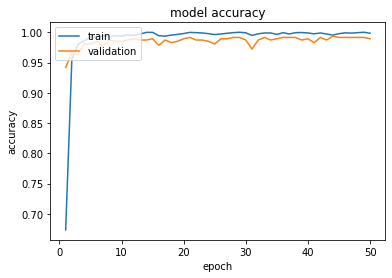

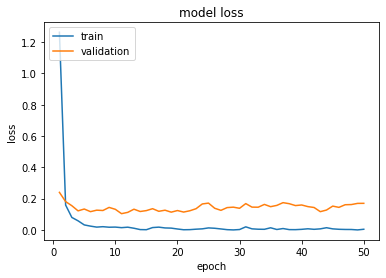

In [10]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epoch_list = [i+1 for i in range(len(loss))]


plt.plot(epoch_list, accuracy)
plt.plot(epoch_list, val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(epoch_list, loss)
plt.plot(epoch_list, val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Step4: 模型預測

In [14]:
def my_predict(img_path):
    try:
        img, extracted_boxes = find_bbox(img_path)
    except: 
         return 'connot recognize'
    res = []
    for i in range(4): 
        x, y, w, h = extracted_boxes[i]
        x, y = abs(x), abs(y)
        crop_img = cv2.resize(img[y:y+h, x:x+w], (img_width, img_height), interpolation=cv2.INTER_AREA)
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        crop_img = np.reshape(crop_img, (1, img_height, img_width, channel))
        crop_img = crop_img/255
        res.append(characters[np.argmax(model.predict(crop_img)[0])])
    return ''.join(res)

In [28]:
correct_count = 0

for file_name in os.listdir('./crop_image/test/'):
    path = './crop_image/test/' + file_name
    if file_name.split('.')[0] == my_predict(path):
        correct_count +=1
        
print('測試準確度為:', correct_count/len(os.listdir('./crop_image/test/')))

測試準確度為: 0.935
